In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
import pandas as pd
import numpy as np

# Read the data from a CSV file.
# Make sure to update the file path to your CSV file.
df = pd.read_csv("model_stats.csv")

# Create a label: if 'Other' is "NA" (or missing), use "Model_Fusion"; otherwise, include "Other" as well.
def create_label(row):
    if pd.isna(row['Other']) or row['Other'] == 'NA':
        return f"{row['Model']}_{row['Fusion']}"
    else:
        return f"{row['Model']}_{row['Fusion']}_{row['Other']}"

df['Label'] = df.apply(create_label, axis=1)

# Calculate the minimum training loss for each model combination.
min_test_lost = df.groupby('Label')['Test_Loss'].min().sort_values()

print("Model combinations sorted by lowest training loss:")
print(min_test_lost)


Model combinations sorted by lowest training loss:
Label
RegNet_Gating                   0.4104
VisTrans16_Gating_two_block     0.4373
VisTrans16_Gating_last_block    0.4506
Res18_MLP_05_dropout            0.4562
Res18_Gating                    0.4768
Res50_Gating                    0.4935
Res18_MLP                       0.4953
Res18_Self_Attention            0.4996
Res50_Gating_class_balance      0.5175
Res18_Bilinear                  0.5367
Name: Test_Loss, dtype: float64


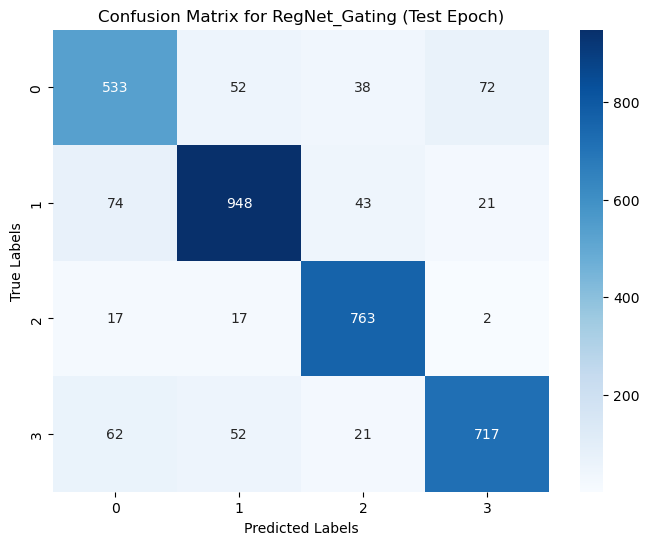

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Specify the model combination to visualize.
model_combo = "RegNet_Gating"

# Filter for the test epoch row for this model combination.
test_row = df[(df['Label'] == model_combo) & (df['Epoch'] == 'Test')]

if test_row.empty:
    print(f"No test epoch found for model combination: {model_combo}")
else:
    # Extract the confusion matrix string.
    cm_str = test_row.iloc[0]['Confusion']
    
    # Helper function to parse the confusion matrix string.
    def parse_confusion_matrix(cm_str):
        # Remove brackets and split by whitespace.
        clean_str = cm_str.replace('[','').replace(']','')
        numbers = list(map(int, clean_str.split()))
        return np.array(numbers).reshape(4, 4)
    
    # Parse the confusion matrix.
    cm = parse_confusion_matrix(cm_str)

    # Plot the heatmap with explicit tick labels.
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_combo} (Test Epoch)")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


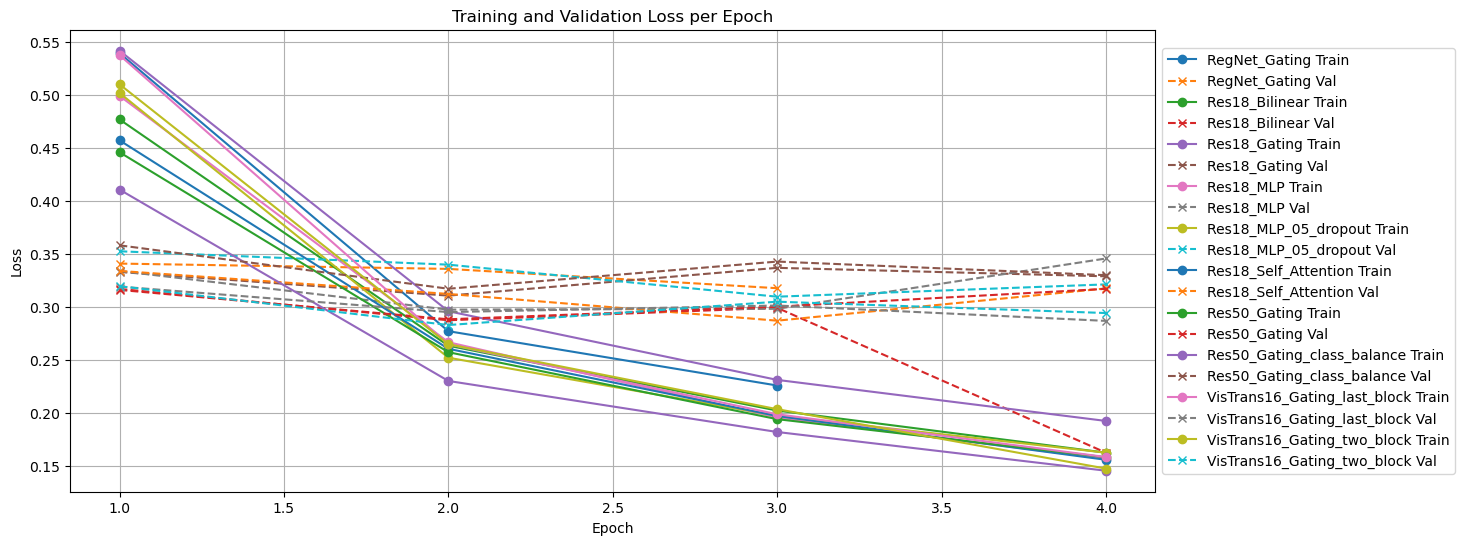

In [6]:
# 1. Line Chart for Training and Validation Loss per Epoch
# Exclude the "Test" rows and convert epoch to integer.
df_train = df[df['Epoch'] != 'Test'].copy()
df_train['Epoch'] = df_train['Epoch'].astype(int)

plt.figure(figsize=(14, 6))
# Group by the model combination label and plot both Train and Val loss.
for label, group in df_train.groupby('Label'):
    plt.plot(group['Epoch'], group['Train_Loss'], marker='o', label=f"{label} Train")
    plt.plot(group['Epoch'], group['Val_Loss'], marker='x', linestyle='--', label=f"{label} Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
# Move legend outside of the plot (to the right side)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


In [9]:
# 2. Calculate Metrics from Test Confusion Matrix and Create a Grouped Bar Chart

# Helper function to parse the confusion matrix string into a numpy array.
def parse_confusion_matrix(cm_str):
    # Remove brackets and extra spaces, then split into numbers.
    cm_str = cm_str.replace('[','').replace(']','')
    numbers = list(map(int, cm_str.split()))
    return np.array(numbers).reshape(4,4)

# Dictionary to store computed metrics for each model combination.
metrics_dict = {}
df_test = df[df['Epoch'] == 'Test']
for idx, row in df_test.iterrows():
    label = row['Label']
    cm = parse_confusion_matrix(row['Confusion'])
    
    # Accuracy: sum of diagonal divided by total sum.
    accuracy = np.trace(cm) / np.sum(cm)
    
    # Compute macro-averaged precision, recall, and F1.
    precisions = []
    recalls = []
    f1s = []
    for i in range(cm.shape[0]):
        # For precision, divide diagonal element by sum of column i.
        col_sum = np.sum(cm[:, i])
        row_sum = np.sum(cm[i, :])
        precision_i = cm[i, i] / col_sum if col_sum > 0 else 0
        recall_i = cm[i, i] / row_sum if row_sum > 0 else 0
        f1_i = 2 * precision_i * recall_i / (precision_i + recall_i) if (precision_i+recall_i)>0 else 0
        
        precisions.append(precision_i)
        recalls.append(recall_i)
        f1s.append(f1_i)
        
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1s)
    
    metrics_dict[label] = {
        'Accuracy': accuracy,
        'Precision': macro_precision,
        'Recall': macro_recall,
        'F1 Score': macro_f1
    }

# Convert the metrics dictionary into a DataFrame.
metrics_df = pd.DataFrame(metrics_dict).T.reset_index().rename(columns={'index': 'Label'})
print(metrics_df)



                          Label  Accuracy  Precision    Recall  F1 Score
0          Res18_Self_Attention  0.850233   0.850307  0.842089  0.844242
1                     Res18_MLP  0.851981   0.854343  0.841796  0.845061
2                Res18_Bilinear  0.837704   0.848204  0.838256  0.835237
3                  Res18_Gating  0.848193   0.853460  0.835388  0.839583
4                  Res50_Gating  0.849942   0.854661  0.840797  0.844726
5    Res50_Gating_class_balance  0.844697   0.846780  0.834974  0.838972
6          Res18_MLP_05_dropout  0.854021   0.851317  0.845253  0.846432
7  VisTrans16_Gating_last_block  0.852273   0.854629  0.844449  0.847792
8   VisTrans16_Gating_two_block  0.856935   0.861050  0.847312  0.851681
9                 RegNet_Gating  0.862762   0.857216  0.859082  0.857641


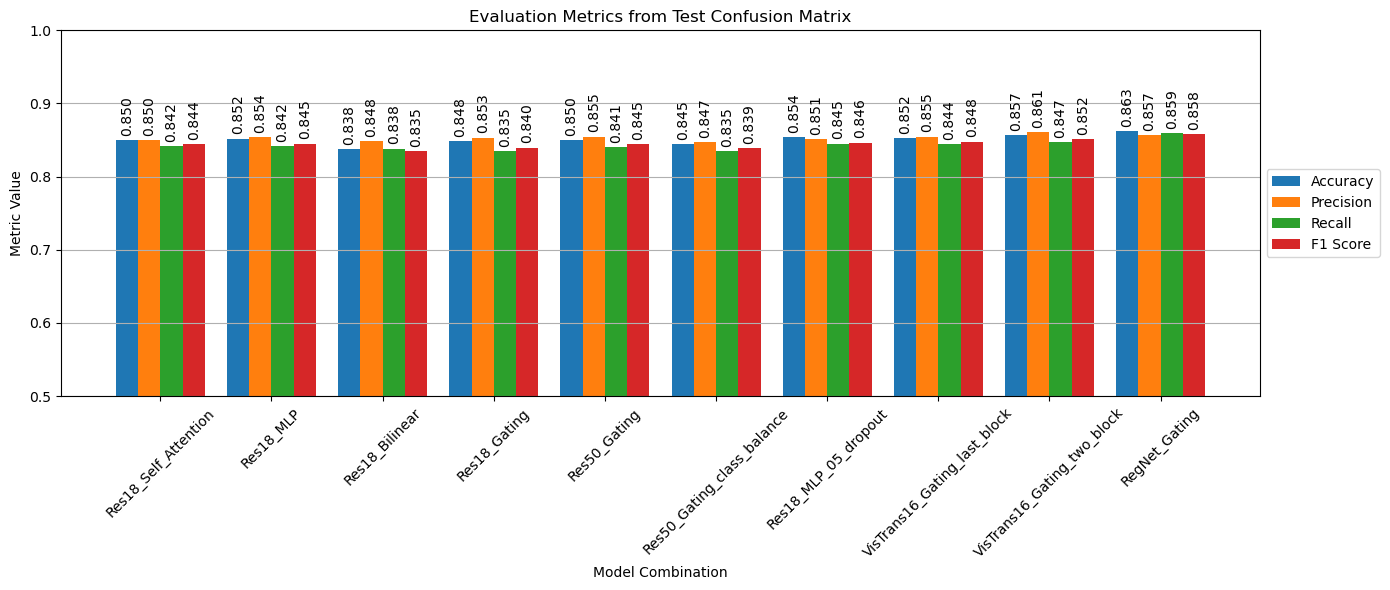

In [18]:
# %% [code]
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and set up the x locations and bar width.
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics_df))  # one group per model combination
width = 0.2  # width of each bar

fig, ax = plt.subplots(figsize=(14, 6))
for i, metric in enumerate(metrics):
    # Plot the bars for this metric.
    bars = ax.bar(x + i * width, metrics_df[metric], width, label=metric)
    # Annotate the value above each bar, rotating the text by 90°.
    bar_labels = ax.bar_label(bars, padding=3, fmt='%.3f')
    for label in bar_labels:
        label.set_rotation(90)

# Set labels and title.
ax.set_xlabel("Model Combination")
ax.set_ylabel("Metric Value")
ax.set_title("Evaluation Metrics from Test Confusion Matrix")
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(metrics_df['Label'], rotation=45)

# Add a y-axis grid.
ax.yaxis.grid(True)

# Set y-axis limits to display values between 0.5 and 1.
ax.set_ylim(0.5, 1)

# Move the legend outside the plot (to the right side).
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
